# Taxi Tip

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/IBM_AI_Engineering/portfolio-6.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

**Objective**: Train a regression model to predict the amount of a taxi tip.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
sns.set_style("whitegrid")

## Load the dataset

In [ ]:
file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv'
df = pd.read_csv(file_url)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


## Understand the dataset

The dataset includes information about the amount of taxi tip paid. The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The dataset records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. 

The TLC Yellow Taxi Trip Records of June, 2019 are used in this notebook. Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables. One variable is called tip_amount and represents the target variable.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936004 entries, 0 to 3936003
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           float64
 8   DOLocationID           float64
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(14), int64(1), object(3)
memory usage: 540.5+ MB


## Preprocess the dataset

In [4]:
original_size = df.size

# Some trips report $0 tip, so it is assumed that these tips were paid in cash. For this study we drop all these rows.
df = df[df['tip_amount'] > 0]

# We also remove some outliers, namely those where the tip was larger than the fare cost.
df = df[(df['tip_amount'] <= df['fare_amount'])]

# We remove trips with very large fare cost.
df = df[((df['fare_amount'] >=2) & (df['fare_amount'] < 200))]

# We drop variables that include the target variable in it, namely the total_amount.
df = df.drop(['total_amount'], axis=1)

cleaned_size = df.size
print("The dataset was reduced by {:.2f}%".format((1 - cleaned_size / original_size) * 100))

The dataset was reduced by 34.91%


In [5]:
# Convert 'tpep_dropoff_datetime' and 'tpep_pickup_datetime' columns to datetime objects.
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract pickup and dropoff hour.
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

# Extract pickup and dropoff day of the week (0 = Monday, 6 = Sunday).
df['pickup_day'] = df['tpep_pickup_datetime'].dt.weekday
df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.weekday

# Calculate trip time in seconds.
df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()

# Drop the pickup and dropoff datetimes.
df = df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

## Visualize the dataset

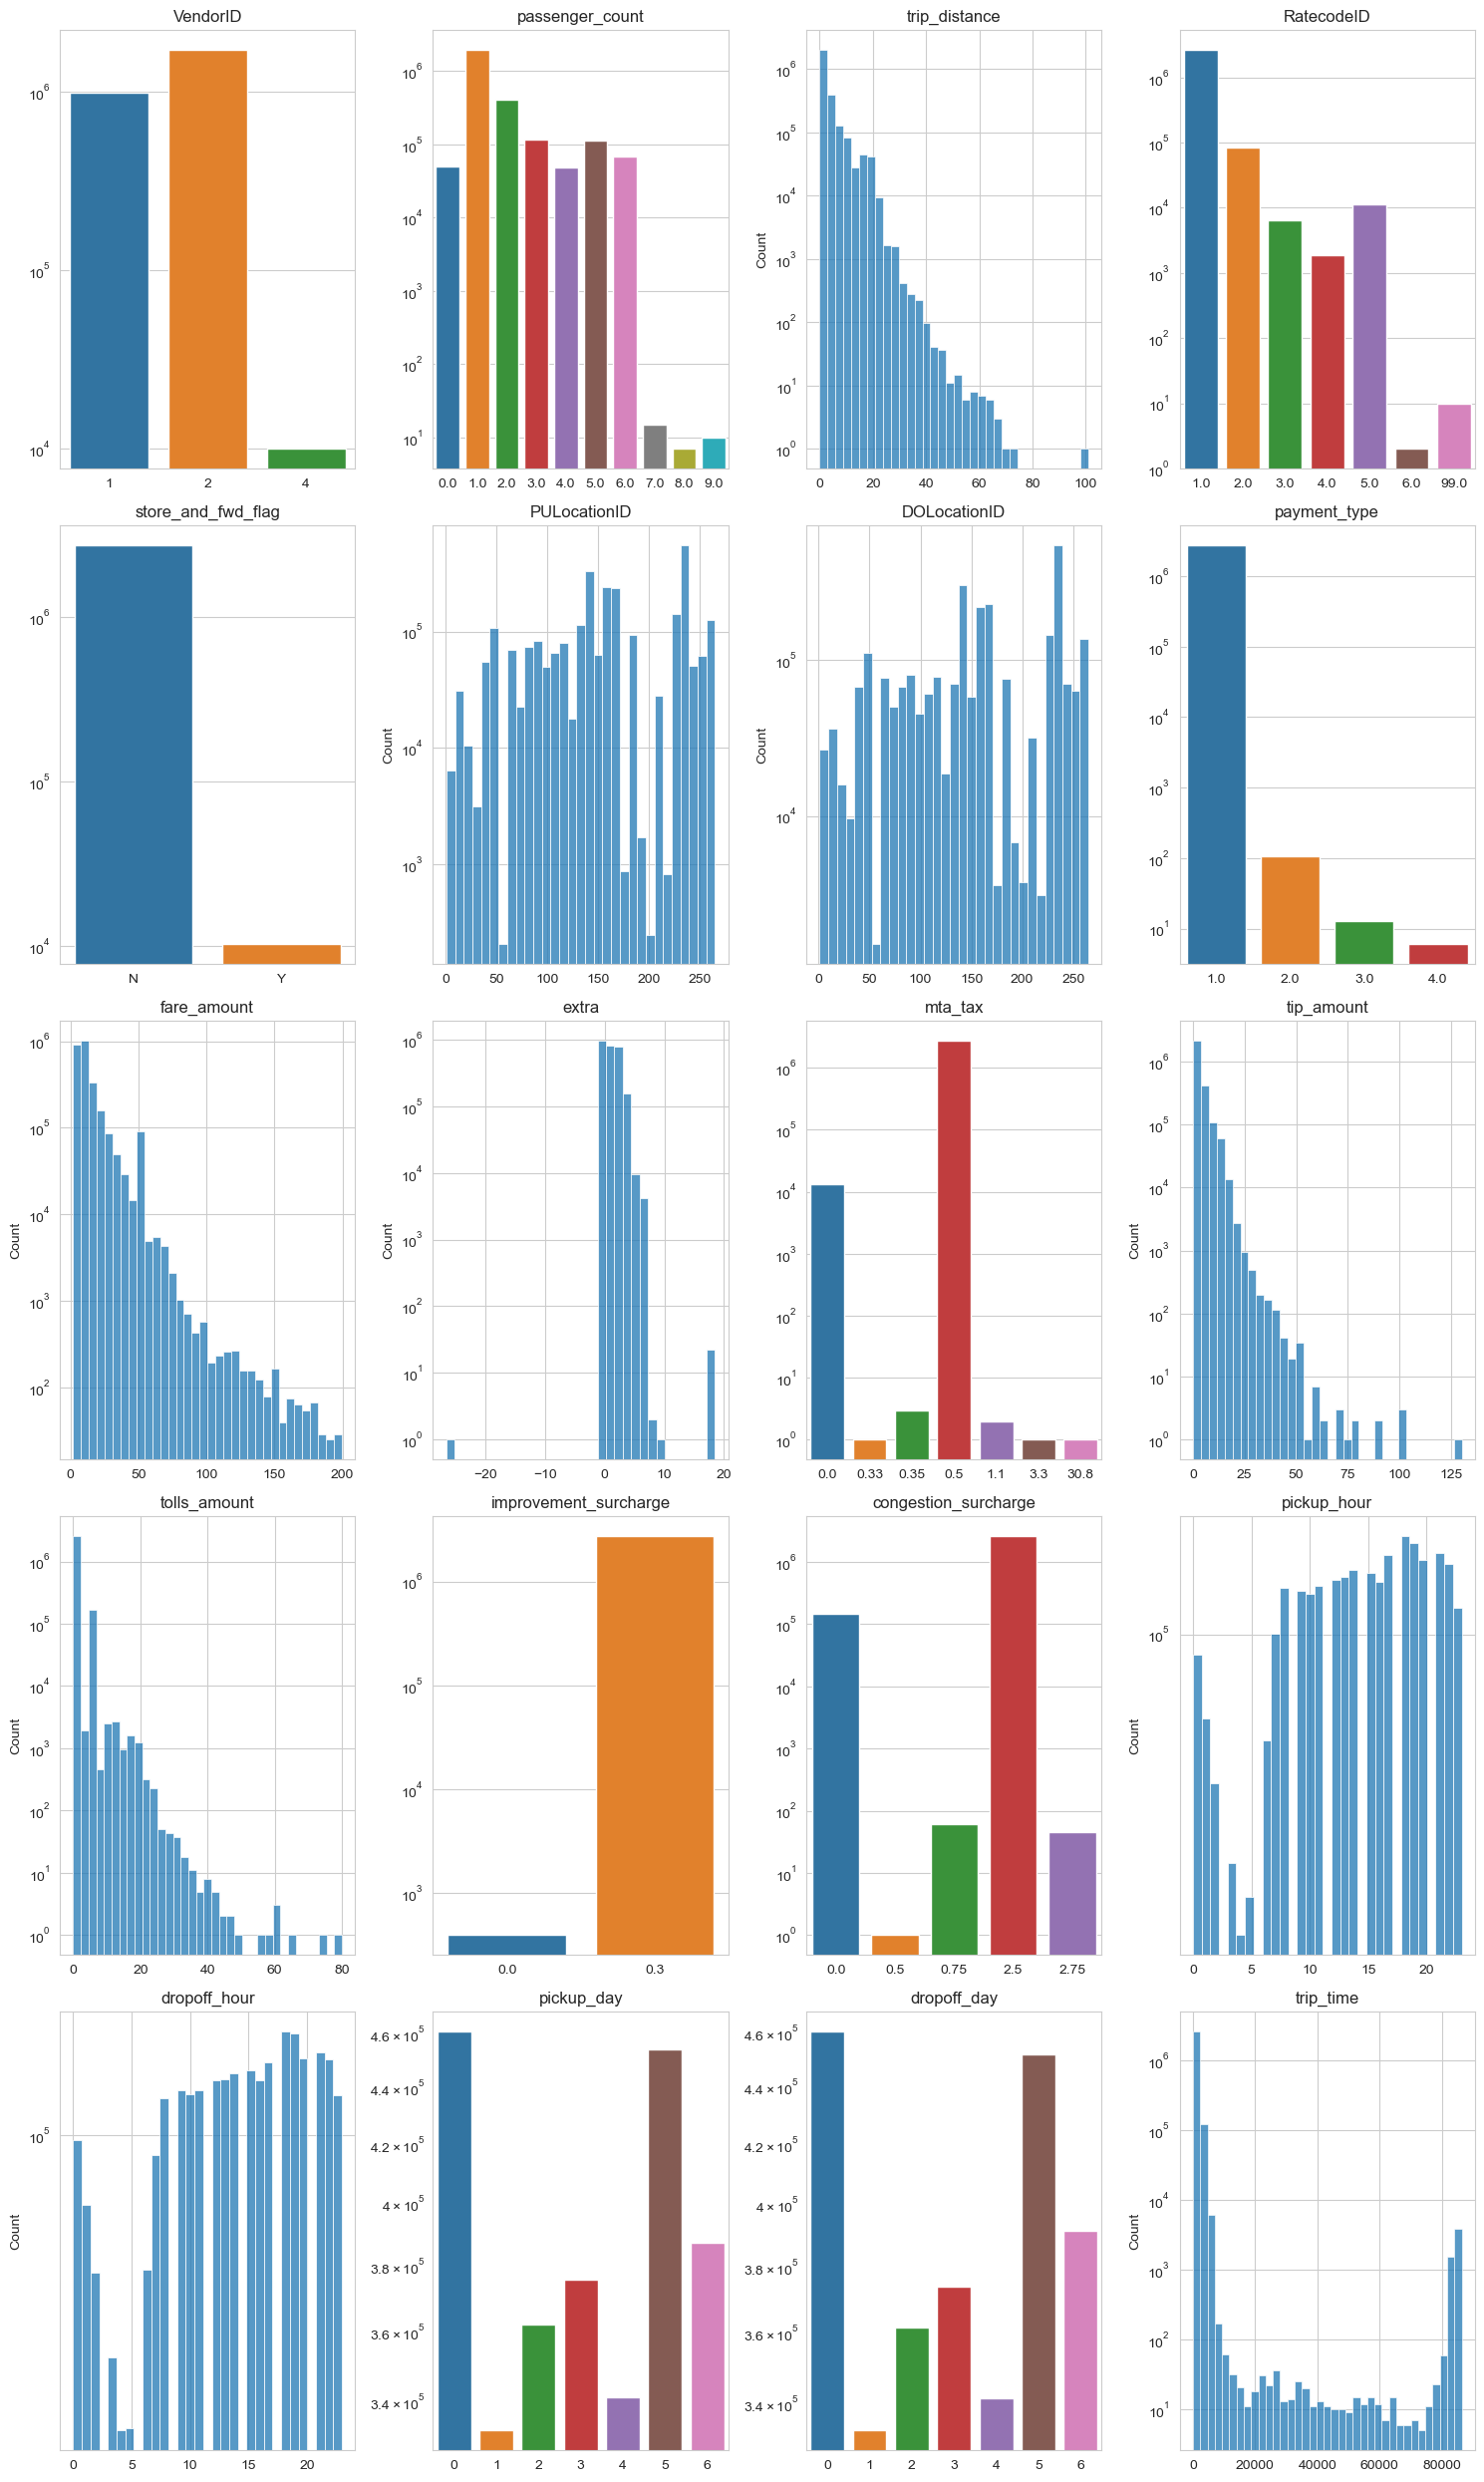

In [6]:
fig, axs = plt.subplots(5, 4, figsize=(15, 25))

for ax, feature in zip(axs.flatten(), df.columns):
    if len(df[feature].unique()) <= 10:
        labels, sizes = np.unique(df[feature], return_counts=True)
        sns.barplot(x=labels, y=sizes, hue=labels, ax=ax, palette="tab10", legend=False)
        ax.set_xlabel("")
        ax.set_yscale("log")
        ax.set_title(feature)
    else:
        sns.histplot(data=df, x=feature, ax=ax, bins="doane")
        ax.set_xlabel("")
        ax.set_yscale("log")
        ax.set_title(feature)

plt.tight_layout()
plt.show()

## Convert categorical variable into dummy/indicator variables

In [7]:
categorical_columns = ["VendorID", "RatecodeID", "store_and_fwd_flag", "PULocationID", "DOLocationID", "payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df.head()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,trip_time,...,pickup_day_3,pickup_day_4,pickup_day_5,pickup_day_6,dropoff_day_1,dropoff_day_2,dropoff_day_3,dropoff_day_4,dropoff_day_5,dropoff_day_6
4,1.0,1.70,9.5,3.0,0.5,2.65,0.0,0.3,2.5,737.0,...,False,False,True,False,False,False,False,False,True,False
5,2.0,1.60,9.5,3.0,0.5,1.00,0.0,0.3,2.5,652.0,...,False,False,True,False,False,False,False,False,True,False
7,2.0,1.20,7.5,3.0,0.5,1.00,0.0,0.3,2.5,488.0,...,False,False,True,False,False,False,False,False,True,False
9,1.0,8.60,31.5,3.0,0.5,7.05,0.0,0.3,2.5,2041.0,...,False,False,True,False,False,False,False,False,True,False
10,1.0,1.74,11.0,0.5,0.5,2.96,0.0,0.3,2.5,858.0,...,False,False,True,False,False,False,False,False,True,False


## Split the dataset into train and test subsets

In [8]:
# Use only the first 200,000 to avoid out-of-memory issues
df = df[:200000]
X = df.drop("tip_amount", axis=1)
y = df["tip_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (150000, 586)
X_test shape: (50000, 586)


## Train a Decision Tree regressor

In [9]:
regressor = DecisionTreeRegressor(max_depth=8)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8)

## Evaluate the model

In [10]:
y_pred = regressor.predict(X_test)

print(f"MSE = {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² = {r2_score(y_test, y_pred):.2f}")

MSE = 1.56
R² = 0.73
